In [2]:
import numpy as np
import pandas as pd
import scipy.sparse as sp

In [3]:
def map_data(data):
    """
    From IGMC data_utils.py
    Map data to proper indices in case they are not in a continues [0, N) range

    Parameters
    ----------
    data : np.int32 arrays

    Returns
    -------
    mapped_data : np.int32 arrays
    n : length of mapped_data

    """
    uniq = list(set(data))

    id_dict = {old: new for new, old in enumerate(sorted(uniq))}
    data = np.array([id_dict[x] for x in data])
    n = len(uniq)

    return data, id_dict, n

In [4]:
def get_movies_data(filepath=None, separator=None, movies_columns_to_drop=None):
    movie_headers = ['item', 'title', 'genres', 'mean', 'popularity', 'mean_unbiased', 
                    '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children',
                    'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
                    'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
                    'War', 'Western']

    movie_df = pd.read_csv(filepath, sep=separator, header=None,
                           names=movie_headers, engine='python', encoding='ISO-8859-1', skiprows=1)
    for column_to_drop in movies_columns_to_drop:
        if column_to_drop in movie_df.columns:
            movie_df.drop(column_to_drop, axis=1, inplace=True)
    genre_headers = movie_df.columns.values[7:]
    num_genres = genre_headers.shape[0]
    return movie_df, genre_headers, num_genres

In [5]:
def get_ratings_data(filepath=None, separator=None, dtypes=None):
    return pd.read_csv(
        filepath, sep=separator, header=None,
        names=["user", "item", "rating", "timestamp"], dtype=dtypes, skiprows=1)

In [6]:
def preprocess_data_to_graph(data_array, testing=False, rating_map=None, post_rating_map=None, ratio=1.0, dtypes=None, class_values=None):
    """
    Loads official train/test split and uses 10% of training samples for validaiton
    For each split computes 1-of-num_classes labels. Also computes training
    adjacency matrix. Assumes flattening happens everywhere in row-major fashion.
    """
    if ratio < 1.0:
        data_array = data_array[data_array[:, -1].argsort()[:int(ratio*len(data_array))]]

    user_nodes_ratings = data_array[:, 0].astype(dtypes['user'])
    item_nodes_ratings = data_array[:, 1].astype(dtypes['item'])
    ratings = data_array[:, 2].astype(dtypes['rating'])
    if rating_map is not None:
        for i, x in enumerate(ratings):
            ratings[i] = rating_map[x]

    user_nodes_ratings, user_dict, num_users = map_data(user_nodes_ratings)
    item_nodes_ratings, item_dict, num_items = map_data(item_nodes_ratings)

    user_nodes_ratings, item_nodes_ratings, ratings = user_nodes_ratings.astype(np.int64), item_nodes_ratings.astype(np.int32), ratings.astype(np.float64)

    neutral_rating = -1  # int(np.ceil(np.float(num_classes)/2.)) - 1

    # assumes that ratings_train contains at least one example of every rating type
    rating_dict = {r: i for i, r in enumerate(class_values.tolist())}

    labels = np.full((num_users, num_items), neutral_rating, dtype=np.int32)
    labels[user_nodes_ratings, item_nodes_ratings] = np.array([rating_dict[r] for r in ratings])

    for i in range(len(user_nodes_ratings)):
        assert(labels[user_nodes_ratings[i], item_nodes_ratings[i]] == rating_dict[ratings[i]])

    labels = labels.reshape([-1])

    # number of test and validation edges, see cf-nade code

    num_edges = data_array.shape[0]

    pairs_nonzero = np.array([[u, v] for u, v in zip(user_nodes_ratings, item_nodes_ratings)])
    idx_nonzero = np.array([u * num_items + v for u, v in pairs_nonzero])

    for i in range(len(ratings)):
        assert(labels[idx_nonzero[i]] == rating_dict[ratings[i]])

    assert(len(idx_nonzero) == num_edges)

    user_idx, item_idx = pairs_nonzero.transpose()

    # create labels
    nonzero_labels = labels[idx_nonzero]

    # make training adjacency matrix
    rating_mx_train = np.zeros(num_users * num_items, dtype=np.float32)
    if post_rating_map is None:
        rating_mx_train[idx_nonzero] = labels[idx_nonzero].astype(np.float32) + 1.
    else:
        rating_mx_train[idx_nonzero] = np.array([post_rating_map[r] for r in class_values[labels[idx_nonzero]]]) + 1.
    rating_mx_train = sp.csr_matrix(rating_mx_train.reshape(num_users, num_items))

    return rating_mx_train, nonzero_labels, user_idx, item_idx, item_dict

In [7]:
def get_movies_features(movie_df, item_dict, genre_headers, num_genres):
    item_features = np.zeros((len(item_dict.keys()), num_genres), dtype=np.float32)
    for movie_id, g_vec in zip(movie_df['item'].values.tolist(), movie_df[genre_headers].values.tolist()):
        # check if movie_id was listed in ratings file and therefore in mapping dictionary
        if movie_id in item_dict.keys():
            item_features[item_dict[movie_id], :] = g_vec
    return item_features

In [8]:

movie_df, genre_headers, num_genres = get_movies_data(filepath='data/movies.csv', separator=r',', movies_columns_to_drop=['genres'])

dtypes = {
    'user': np.int32, 'item': np.int32,
    'rating': np.float32, 'timestamp': np.float64}

data_train = get_ratings_data(filepath='data_small/train.csv', separator=r',', dtypes=dtypes)
data_val = get_ratings_data(filepath='data_small/validate.csv', separator=r',', dtypes=dtypes)
data_test = get_ratings_data(filepath='data_small/test.csv', separator=r',', dtypes=dtypes)

data_array_train = np.array(data_train.values.tolist())
data_array_val = np.array(data_val.values.tolist())
data_array_test = np.array(data_test.values.tolist())

class_values = np.array([0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5], dtype=dtypes['rating'])

# add features for whole dataset TODO
train_adjacency_mx, train_labels, train_user_idx, train_item_idx, train_item_dict = preprocess_data_to_graph(data_array_train, dtypes=dtypes, class_values=class_values)
train_item_features = sp.csr_matrix(get_movies_features(movie_df, train_item_dict, genre_headers, num_genres))
val_adjacency_mx, val_labels, val_user_idx, val_item_idx, val_item_dict = preprocess_data_to_graph(data_array_val, dtypes=dtypes, class_values=class_values)
val_item_features = sp.csr_matrix(get_movies_features(movie_df, val_item_dict, genre_headers, num_genres))
test_adjacency_mx, test_labels, test_user_idx, test_item_idx, test_item_dict = preprocess_data_to_graph(data_array_test, dtypes=dtypes, class_values=class_values)
test_item_features = sp.csr_matrix(get_movies_features(movie_df, test_item_dict, genre_headers, num_genres))

print("Train item features shape: "+str(train_item_features.shape))
print("Validation item features shape: "+str(val_item_features.shape))
print("Test item features shape: "+str(test_item_features.shape))


Train item features shape: (8500, 18)
Validation item features shape: (5536, 18)
Test item features shape: (3975, 18)


In [9]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch.optim import Adam
from torch_geometric.data import DataLoader
from torch_geometric.nn import RGCNConv
from torch_geometric.utils import dropout_adj
from IGMC.util_functions import *
from IGMC.data_utils import *
from IGMC.preprocessing import *

In [10]:
use_item_features = True

In [11]:
train_item_features_array = train_item_features.toarray() if use_item_features else None

train_dataset = eval('MyDynamicDataset')(root='data_test/processed/train', A=train_adjacency_mx, 
    links=(train_user_idx, train_item_idx), labels=train_labels, h=1, sample_ratio=1.0, 
    max_nodes_per_hop=200, u_features=None, v_features=train_item_features_array, class_values=class_values)
test_dataset = eval('MyDataset')(root='data_test/processed/test', A=test_adjacency_mx, 
    links=(test_user_idx, test_item_idx), labels=test_labels, h=1, sample_ratio=1.0, 
    max_nodes_per_hop=200, u_features=None, v_features=train_item_features_array, class_values=class_values)

Enclosing subgraph extraction begins...


Processing...
 91%|█████████ | 29/32 [00:10<00:01,  2.81it/s]


Time elapsed for subgraph extraction: 10.754051923751831s
Transforming to pytorch_geometric graphs...


100%|██████████| 15061/15061 [00:03<00:00, 4628.64it/s]


Time elapsed for transforming to pytorch_geometric graphs: 3.263993263244629s


Done!


In [12]:
import torch
import math
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import RGCNConv
from torch_geometric.utils import dropout_adj

In [33]:

class IGMC(torch.nn.Module):
    def __init__(self):
        super(IGMC, self).__init__()
        self.rel_graph_convs = torch.nn.ModuleList()
        self.rel_graph_convs.append(RGCNConv(in_channels=4, out_channels=32,\
                                             num_relations=5, num_bases=4))
        self.rel_graph_convs.append(RGCNConv(in_channels=32, out_channels=32\
                                             , num_relations=5, num_bases=4))
        self.rel_graph_convs.append(RGCNConv(in_channels=32, out_channels=32,\
                                             num_relations=5, num_bases=4))
        self.rel_graph_convs.append(RGCNConv(in_channels=32, out_channels=32,\
                                             num_relations=5, num_bases=4))
        self.linear_layer1 = Linear(256, 128)
        self.linear_layer2 = Linear(128, 1)

    def reset_parameters(self):
        self.linear_layer1.reset_parameters()
        self.linear_layer2.reset_parameters()
        for i in self.rel_graph_convs:
            i.reset_parameters()

    def forward(self, data):
        # print("data.x")
        # print(data.x)
        num_nodes = len(data.x)
        edge_index_dr, edge_type_dr = dropout_adj(data.edge_index, data.edge_type,\
                                p=0.2, num_nodes=num_nodes, training=self.training)

        # print(data.edge_index == edge_index_dr)
        # print(data.edge_type == edge_type_dr)
        out = data.x
        h = []
        for conv in self.rel_graph_convs:
            out = conv(out, edge_index_dr, edge_type_dr)
            out = torch.tanh(out)
            h.append(out)
        h = torch.cat(h, 1)
        h = [h[data.x[:, 0] == True], h[data.x[:, 1] == True]]
        g = torch.cat(h, 1)
        out = self.linear_layer1(g)
        out = F.relu(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.linear_layer2(out)
        out = out[:,0]
        return out

model = IGMC()


In [14]:
LR = 1e-3
EPOCHS = 10
BATCH_SIZE = 50
LR_DECAY_STEP = 20
LR_DECAY_VALUE = 10

train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2)

device = torch.device("cpu")
model.to(device)
model.reset_parameters()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=0)

/Users/user/Documents/Nauka/Studia/Magisterskie/Magisterka/Recommender/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [80]:


def get_movie_ids_to_predict(user_ratings, all_movies):
    all_movie_ids = all_movies['item'].unique()
    user_rating_ids = user_ratings['item'].unique()
    #
    return [idx for idx in all_movie_ids if idx not in user_rating_ids]

def populate_with_dummy_graphs(inference_data, movies_to_predict):
    timestamp = 945173447
    dummy_review = 2.0
    user_min_idx = all_data['user'].max() + 1
    graphs_for_inference = inference_data.iloc[:0,:].copy()
    for i, movie_id in enumerate(movies_to_predict):
        dummy_inference_graph = inference_data.copy()
        user_idx = user_min_idx + i
        dummy_inference_graph['user'] = user_idx
        list_row = [user_idx, movie_id, dummy_review, timestamp]
        dummy_inference_graph.loc[len(dummy_inference_graph)] = list_row
        graphs_for_inference = pd.concat([graphs_for_inference, dummy_inference_graph], ignore_index=True)
    return graphs_for_inference

def add_additional_row_for_dataloader(df, i):
    list_row = [i, 0, 3.0, 999999999]
    df.loc[len(df)] = list_row

from torch_geometric.loader import DataLoader

model_load = IGMC()
model_load.load_state_dict(torch.load("models/graph_80epochs_wo_features.pt"))
model_load.eval()

all_data = pd.concat([data_train, data_test, data_val], ignore_index=True)
all_movies, _, _ = get_movies_data(filepath='data_small/movies.csv', separator=r',', movies_columns_to_drop=['genres'])

inference_data = get_ratings_data(filepath='my_reviews/1.csv', separator=r',', dtypes=dtypes)
input_length = len(inference_data)
movies_to_predict = get_movie_ids_to_predict(inference_data, all_movies)

print("Creating dummy graphs...")
dummy_graphs_for_inference = populate_with_dummy_graphs(inference_data, movies_to_predict)
print("Graphs created. Concating dummy graphs with main data graph...")
graph_for_inference = pd.concat([dummy_graphs_for_inference, data_train, data_test, data_val], ignore_index=True)
print("Done")

# add_additional_row_for_dataloader(graphs_for_inference, item_indices_to_predict[-1] + 1)
print("Creating dataset as array...")
my_data_array = np.array(graph_for_inference.values.tolist())
my_adjacency_mx, my_labels, my_user_idx, my_item_idx, my_item_dict = preprocess_data_to_graph(my_data_array, dtypes=dtypes, class_values=class_values)
my_dataset = MyDynamicDataset(root='data_test/processed/test', A=my_adjacency_mx, 
    links=(my_user_idx, my_item_idx), labels=my_labels, h=1, sample_ratio=1.0, 
    max_nodes_per_hop=200, u_features=None, v_features=None, class_values=class_values)
print("Done. Creating dataloader...")
my_data_loader = DataLoader(my_dataset, input_length + 1, shuffle=False, num_workers=1)
batches_in_my_loader = len(my_data_loader)
batches_for_prediction = len(movies_to_predict)
print(f"Done. Batches in dataloader: {batches_in_my_loader}. Batches actually used in inference: {batches_for_prediction}")
predictions = dict()
print("Starting inference")
for i, test_batch in enumerate(my_data_loader):
    print(f"{i}/{batches_for_prediction - 1}")

    test_batch = test_batch.to(device)
    with torch.no_grad():
        y_my_pred = model_load(test_batch)
    torch.cuda.empty_cache()
    predictions[movies_to_predict[i]] = y_my_pred[-1].item()
    if i == batches_for_prediction -1:
        break
    
    # print("data x")
    # print(test_batch.x)
    # print("stop")
    # print(y_my_pred)
    # # print(y_my_pred[-1].item())
    # print(test_batch.y)
    # print(test_batch)
    # test_x = test_batch.x
    # test_x_set = True
    # to_predict = time.time()
    # # print(f"dummy: {dummy_graphs - start}")
    # # print(f"dataset_create: {dataset_create - dummy_graphs}")
    # # print(f"dataloader_create: {dataloader_create - dataset_create}")
    # # print(f"to_start_iterating: {to_start_iterating - dataloader_create}")
    # # print(f"to_predict: {to_predict - to_start_iterating}")
    # start = time.time()
# end = time.time()

# # mse_loss = float(test_loss) / len(test_loader.dataset)
# print(predictions)
print(max(predictions, key=predictions.get))
# # print('test MSE loss', mse_loss)
# # print('test RMSE loss', math.sqrt(mse_loss))

Creating dummy graphs...
Graphs created. Concating dummy graphs with main data graph...
Done
Creating dataset as array...
Done. Creating dataloader...
Done. Batches in dataloader: 26525. Batches actually used in inference: 9719
Starting inference
0/9718
1/9718
2/9718
3/9718
4/9718
5/9718
6/9718
7/9718


/Users/user/Documents/Nauka/Studia/Magisterskie/Magisterka/Recommender/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


8/9718
9/9718
10/9718
11/9718
12/9718
13/9718
14/9718
15/9718
16/9718
17/9718
18/9718
19/9718
20/9718
21/9718
22/9718
23/9718
24/9718
25/9718
26/9718
27/9718
28/9718
29/9718
30/9718
31/9718
32/9718
33/9718
34/9718
35/9718
36/9718
37/9718
38/9718
39/9718
40/9718
41/9718
42/9718
43/9718
44/9718
45/9718
46/9718
47/9718
48/9718
49/9718
50/9718
51/9718
52/9718
53/9718
54/9718
55/9718
56/9718
57/9718
58/9718
59/9718
60/9718
61/9718
62/9718
63/9718
64/9718
65/9718
66/9718
67/9718
68/9718
69/9718
70/9718
71/9718
72/9718
73/9718
74/9718
75/9718
76/9718
77/9718
78/9718
79/9718
80/9718
81/9718
82/9718
83/9718
84/9718
85/9718
86/9718
87/9718
88/9718
89/9718
90/9718
91/9718
92/9718
93/9718
94/9718
95/9718
96/9718
97/9718
98/9718
99/9718
100/9718
101/9718
102/9718
103/9718
104/9718
105/9718
106/9718
107/9718
108/9718
109/9718
110/9718
111/9718
112/9718
113/9718
114/9718
115/9718
116/9718
117/9718
118/9718
119/9718
120/9718
121/9718
122/9718
123/9718
124/9718
125/9718
126/9718
127/9718
128/9718
129/9

In [81]:
i = 0
d_view = [ (v,k) for k,v in predictions.items() ]
d_view.sort(reverse=True) # natively sort tuples by first element
for v,k in d_view:
    if i == 10:
        break
    print(f"idx {k}; {all_movies.loc[all_movies['item'] == k]}: {v}")
    i +=1

2144: 4.367048263549805
1079: 4.326338768005371
1952: 4.2977094650268555
1953: 4.29758882522583
3897: 4.261466979980469
8958: 4.2592597007751465
4359: 4.258538246154785
1278: 4.255062580108643
4954: 4.251676082611084
2788: 4.2516632080078125


In [105]:
loss_through_epochs = []
batches_per_epoch = len(train_loader)
for epoch in range(1, EPOCHS+1):
    model.train()
    train_loss_all = 0
    for i, train_batch in enumerate(train_loader):
        if i % 100 == 0 or i % batches_per_epoch == 0:
            print(f"{i}/{batches_per_epoch}")
        optimizer.zero_grad()
        train_batch = train_batch.to(device)
        y_pred = model(train_batch)
        y_true = train_batch.y
        train_loss = F.mse_loss(y_pred, y_true)
        train_loss.backward()
        train_loss_all += BATCH_SIZE * float(train_loss)
        optimizer.step()
        torch.cuda.empty_cache()
    train_loss_all = train_loss_all / len(train_loader.dataset)
    loss_through_epochs.append(train_loss_all)
    print('epoch', epoch,'; train loss', train_loss_all)

    if epoch % LR_DECAY_STEP == 0:
      for param_group in optimizer.param_groups:
          param_group['lr'] = param_group['lr'] / LR_DECAY_VALUE

0/1370


/Users/user/Documents/Nauka/Studia/Magisterskie/Magisterka/Recommender/.venv/lib/python3.9/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'dropout_adj' is deprecated, use 'dropout_edge' instead
  warnings.warn(out)


100/1370
200/1370
300/1370
400/1370
500/1370
600/1370
700/1370
800/1370
900/1370
1000/1370
1100/1370
1200/1370
1300/1370
epoch 1 ; train loss 1.3001574559911027
0/1370
100/1370
200/1370
300/1370
400/1370
500/1370
600/1370
700/1370
800/1370
900/1370
1000/1370
1100/1370
1200/1370
1300/1370
epoch 2 ; train loss 1.1242069229695717
0/1370
100/1370
200/1370
300/1370
400/1370
500/1370
600/1370
700/1370
800/1370
900/1370
1000/1370
1100/1370
1200/1370
1300/1370
epoch 3 ; train loss 1.0605749349296854
0/1370
100/1370
200/1370
300/1370
400/1370
500/1370
600/1370
700/1370
800/1370
900/1370
1000/1370
1100/1370
1200/1370
1300/1370
epoch 4 ; train loss 1.0077717249580904
0/1370
100/1370
200/1370
300/1370
400/1370
500/1370
600/1370
700/1370
800/1370
900/1370
1000/1370
1100/1370
1200/1370
1300/1370
epoch 5 ; train loss 0.9709848268283215
0/1370
100/1370
200/1370
300/1370
400/1370
500/1370
600/1370
700/1370
800/1370
900/1370
1000/1370
1100/1370
1200/1370
1300/1370
epoch 6 ; train loss 0.9429209776338552

In [71]:
# epochs_20_without_features_loss = loss_through_epochs

In [81]:
# epochs_80_without_features_loss = loss_through_epochs

In [106]:
epochs_10_with_features = loss_through_epochs
print(epochs_10_with_features)

[1.3001574559911027, 1.1242069229695717, 1.0605749349296854, 1.0077717249580904, 0.9709848268283215, 0.9429209776338552, 0.9213795889223637, 0.9038183175087741, 0.8935134785176542, 0.8876384221791299]


In [82]:
print(epochs_80_without_features_loss)

[1.263130319728513, 1.1143163437651529, 1.0489432879743528, 1.0011662990648873, 0.9719658813404162, 0.9473816369630897, 0.9271165914140101, 0.910215341280791, 0.8994110352941321, 0.8948708321545383, 0.8846682264853746, 0.881532131842396, 0.8778387994276833, 0.8771689812565678, 0.8744101944792244, 0.8702662211020016, 0.8723400851150213, 0.8651852734994432, 0.865462982869512, 0.8611578125833238, 0.8451877044355689, 0.8432373293116716, 0.8430247139657481, 0.8390545279181381, 0.8400035634363853, 0.8374447528746313, 0.8398014413839675, 0.8352425645734195, 0.8374225730199485, 0.8361313110964604, 0.8356438659300673, 0.8373478306054251, 0.8371956511016866, 0.8360716218678252, 0.8369672804020105, 0.834203694817689, 0.835111934591866, 0.8347405718098471, 0.833042248233982, 0.8315830910908096, 0.8293700215154969, 0.8295018811827725, 0.8318793025057858, 0.8286850298745013, 0.8281826880719768, 0.8307953076089714, 0.8295803324951204, 0.8310552290020411, 0.8307909859567761, 0.8288448147246746, 0.8309

In [56]:
a = [1.243322794737977, 1.087153502446612, 1.0355715633865794, 1.0029200245032424, 0.9713406770000824]
print("Loss from first 5 epochs on 1/100th the dataset and without the feature matrix\n", a)

Loss from first 5 epochs on 1/100th the dataset and without the feature matrix
 [1.243322794737977, 1.087153502446612, 1.0355715633865794, 1.0029200245032424, 0.9713406770000824]


In [72]:
batches_in_eval = len(test_loader)
model.eval()
test_loss = 0
for i, test_batch in enumerate(test_loader):
    print(f"{i}/{batches_in_eval}")
    test_batch = test_batch.to(device)
    with torch.no_grad():
        y_pred = model(test_batch)
    y_true = test_batch.y
    test_loss += F.mse_loss(y_pred, y_true, reduction='sum')
    # torch.cuda.empty_cache()
mse_loss = float(test_loss) / len(test_loader.dataset)

print('test MSE loss', mse_loss)
print('test RMSE loss', math.sqrt(mse_loss))

0/99
1/99
2/99
3/99
4/99
5/99
6/99
7/99
8/99
9/99
10/99
11/99
12/99
13/99
14/99
15/99
16/99
17/99
18/99
19/99
20/99
21/99
22/99
23/99
24/99
25/99
26/99
27/99
28/99
29/99
30/99
31/99
32/99
33/99
34/99
35/99
36/99
37/99
38/99
39/99
40/99
41/99
42/99
43/99
44/99
45/99
46/99
47/99
48/99
49/99
50/99
51/99
52/99
53/99
54/99
55/99
56/99
57/99
58/99
59/99
60/99
61/99
62/99
63/99
64/99
65/99
66/99
67/99
68/99
69/99
70/99
71/99
72/99
73/99
74/99
75/99
76/99
77/99
78/99
79/99
80/99
81/99
82/99
83/99
84/99
85/99
86/99
87/99
88/99
89/99
90/99
91/99
92/99
93/99
94/99
95/99
96/99
97/99
98/99
test MSE loss 0.9694746933974229
test RMSE loss 0.9846190600417112


### Zacznij ponizej
Dataloader sie nie iteruje

In [211]:
batches_in_my_loader = len(my_data_loader)
model.eval()
test_loss = 0
# print(dir(my_data_loader))
# print(my_data_loader[0])
for i, test_batch in enumerate(my_data_loader):
    print(f"{i}/{batches_in_my_loader}")

    #     test_batch = test_batch.to(device)
#     with torch.no_grad():
#         y_my_pred = model(test_batch)
#     y_my_true = test_batch.y
    # test_loss += F.mse_loss(y_pred, y_true, reduction='sum')
    # torch.cuda.empty_cache()
# mse_loss = float(test_loss) / len(test_loader.dataset)

# print('test MSE loss', mse_loss)
# print('test RMSE loss', math.sqrt(mse_loss))

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/user/Documents/Nauka/Studia/Magisterskie/Magisterka/Recommender/.venv/lib/python3.9/site-packages/torch/utils/data/_utils/worker.py", line 302, in _worker_loop
    data = fetcher.fetch(index)
  File "/Users/user/Documents/Nauka/Studia/Magisterskie/Magisterka/Recommender/.venv/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 58, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/user/Documents/Nauka/Studia/Magisterskie/Magisterka/Recommender/.venv/lib/python3.9/site-packages/torch/utils/data/_utils/fetch.py", line 58, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/Users/user/Documents/Nauka/Studia/Magisterskie/Magisterka/Recommender/.venv/lib/python3.9/site-packages/torch_geometric/data/dataset.py", line 239, in __getitem__
    data = self.get(self.indices()[idx])
  File "/Users/user/Documents/Nauka/Studia/Magisterskie/Magisterka/Recommender/IGMC/util_functions.py", line 144, in get
    tmp = subgraph_extraction_labeling(
  File "/Users/user/Documents/Nauka/Studia/Magisterskie/Magisterka/Recommender/IGMC/util_functions.py", line 239, in subgraph_extraction_labeling
    subgraph = Arow[u_nodes][:, v_nodes]
  File "/Users/user/Documents/Nauka/Studia/Magisterskie/Magisterka/Recommender/.venv/lib/python3.9/site-packages/scipy/sparse/_index.py", line 71, in __getitem__
    return self._get_sliceXarray(row, col)
  File "/Users/user/Documents/Nauka/Studia/Magisterskie/Magisterka/Recommender/.venv/lib/python3.9/site-packages/scipy/sparse/_csr.py", line 321, in _get_sliceXarray
    return self._major_slice(row)._minor_index_fancy(col)
  File "/Users/user/Documents/Nauka/Studia/Magisterskie/Magisterka/Recommender/.venv/lib/python3.9/site-packages/scipy/sparse/_compressed.py", line 777, in _minor_index_fancy
    csr_column_index2(col_order, col_offsets, len(self.indices),
ValueError: unsupported data types in input


In [74]:
epochs_20_v_features_loss = loss_through_epochs
epochs_20_v_features_mse = mse_loss
epochs_20_v_features_rmse = math.sqrt(mse_loss)
print(epochs_20_v_features_rmse, epochs_20_v_features_mse)
print(epochs_20_v_features_loss)

0.9846190600417112 0.9694746933974229
[1.2789499702675688, 1.113916638602531, 1.0635456429997434, 1.016766366532044, 0.9875240869979474, 0.9623919475582431, 0.9382708783706302, 0.9232025817324884, 0.9103171136772749, 0.8993105876749472, 0.8933194246298379, 0.8891857290835318, 0.883572374532602, 0.8810392226413337, 0.8764296271033649, 0.8748013486878891, 0.870734680324621, 0.8710751242468466, 0.8683388907071038, 0.8662948521856618]


In [76]:
# torch.save(model.state_dict(), "models/graph_20epochs_wo_features.pt")

In [84]:
# torch.save(model.state_dict(), "models/graph_80epochs_wo_features.pt")
# epochs_80_wo_features_loss = loss_through_epochs
# 271m

In [89]:
torch.save(model.state_dict(), "models/graph_80epochs_with_features.pt")
epochs_80_with_features_loss = loss_through_epochs

In [91]:
print(epochs_80_wo_features_loss)
print(epochs_80_with_features_loss)

[1.263130319728513, 1.1143163437651529, 1.0489432879743528, 1.0011662990648873, 0.9719658813404162, 0.9473816369630897, 0.9271165914140101, 0.910215341280791, 0.8994110352941321, 0.8948708321545383, 0.8846682264853746, 0.881532131842396, 0.8778387994276833, 0.8771689812565678, 0.8744101944792244, 0.8702662211020016, 0.8723400851150213, 0.8651852734994432, 0.865462982869512, 0.8611578125833238, 0.8451877044355689, 0.8432373293116716, 0.8430247139657481, 0.8390545279181381, 0.8400035634363853, 0.8374447528746313, 0.8398014413839675, 0.8352425645734195, 0.8374225730199485, 0.8361313110964604, 0.8356438659300673, 0.8373478306054251, 0.8371956511016866, 0.8360716218678252, 0.8369672804020105, 0.834203694817689, 0.835111934591866, 0.8347405718098471, 0.833042248233982, 0.8315830910908096, 0.8293700215154969, 0.8295018811827725, 0.8318793025057858, 0.8286850298745013, 0.8281826880719768, 0.8307953076089714, 0.8295803324951204, 0.8310552290020411, 0.8307909859567761, 0.8288448147246746, 0.8309

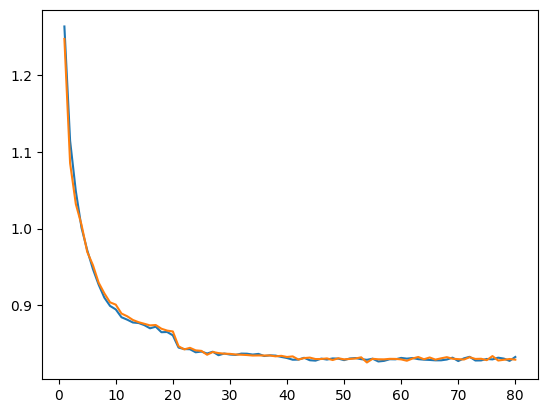

In [93]:
from matplotlib import pyplot as plt

epochs = range(1, len(epochs_80_wo_features_loss) + 1)
plt.plot(epochs, epochs_80_wo_features_loss)
plt.plot(epochs, epochs_80_with_features_loss)
plt.show()

In [77]:
model_load = IGMC()
model_load.load_state_dict(torch.load("models/graph_20epochs_wo_features.pt"))
model_load.eval()

IGMC(
  (rel_graph_convs): ModuleList(
    (0): RGCNConv(4, 32, num_relations=5)
    (1): RGCNConv(32, 32, num_relations=5)
    (2): RGCNConv(32, 32, num_relations=5)
    (3): RGCNConv(32, 32, num_relations=5)
  )
  (linear_layer1): Linear(in_features=256, out_features=128, bias=True)
  (linear_layer2): Linear(in_features=128, out_features=1, bias=True)
)

In [95]:
batches_in_eval = len(test_loader)
model_load.eval()
test_loss = 0
for i, test_batch in enumerate(test_loader):
    print(f"{i}/{batches_in_eval}")
    test_batch = test_batch.to(device)
    with torch.no_grad():
        y_pred = model_load(test_batch)
        print(y_pred)
    y_true = test_batch.y
    test_loss += F.mse_loss(y_pred, y_true, reduction='sum')
    # torch.cuda.empty_cache()
mse_loss = float(test_loss) / len(test_loader.dataset)

print('test MSE loss', mse_loss)
print('test RMSE loss', math.sqrt(mse_loss))

0/99
tensor([3.6836, 3.7394, 3.7394, 3.6278, 3.7394, 3.7394, 3.7863, 3.7394, 3.5629,
        3.7394, 3.7394, 3.5646, 3.7314, 3.7883, 3.7394, 3.7295, 3.6538, 3.7290,
        3.7394, 3.7394, 3.7394, 3.6395, 3.7735, 3.7394, 3.7394, 3.7883, 3.7394,
        3.7394, 3.7394, 3.7863, 3.7863, 3.7394, 3.6401, 3.7394, 3.6437, 3.7394,
        3.7394, 3.7863, 3.7394, 3.7394, 3.5495, 3.7394, 3.6136, 3.7394, 3.7394,
        3.7394, 3.4087, 3.7296, 3.7394, 3.7394])
1/99
tensor([3.7883, 3.7394, 3.7863, 3.6236, 4.0715, 3.7394, 3.7309, 3.7394, 3.7394,
        3.7394, 3.5420, 3.7394, 3.6512, 3.5629, 3.6517, 3.7394, 3.6473, 3.7394,
        3.7394, 3.7883, 3.7514, 3.6182, 3.7199, 3.5743, 3.6762, 3.7394, 3.6144,
        3.6562, 3.7394, 3.7394, 3.7063, 3.5844, 3.7394, 3.6367, 3.5494, 3.7394,
        3.5827, 3.7883, 3.7394, 3.7883, 3.7863, 3.5944, 3.7308, 3.6437, 3.5614,
        3.6500, 3.7394, 3.6437, 3.7394, 3.7863])
2/99
tensor([3.7883, 3.6471, 3.6733, 3.7394, 3.7394, 3.7394, 3.7394, 3.7394, 3.7394,
       

KeyboardInterrupt: 